In [1]:
%pylab inline

/home/gjones/miniconda2/envs/readout/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import signal

In [257]:
signal.correlate??

In [245]:
class HalfBandFilter(object):
    def __init__(self,num_taps=16,window_param=('chebwin',80)):
        self.num_taps = num_taps
        self.window_param=window_param
        self.coeff = signal.firwin(num_taps+1,0.5,window=window_param).astype('float32')
        self.coeff[np.abs(self.coeff)<1e-14]=0.0
        self.polyphase_coeff = self.coeff[1::2]*2
    def naive(self,data):
        return signal.convolve(data,self.coeff,mode='same')
    def polyphase(self,data):
        result = signal.convolve(data[1::2],self.polyphase_coeff,mode='same')
        result += data[::2]
        return result/2.0

In [246]:
class MultistageDecimationFilter(object):
    def __init__(self,taps):
        self.taps = taps
        self.num_stages = taps.size
        self.filters = [HalfBandFilter(num_taps=num_taps) for num_taps in taps]
    def naive(self,data):
        for filter_ in self.filters:
            data = filter_.naive(data)[::2]
        return data
    def polyphase(self,data):
        for filter_ in self.filters:
            data = filter_.polyphase(data)
        return data

In [272]:
xr = np.zeros((2**20,),dtype=np.float32)
xc = np.zeros((2**19,),dtype=np.complex64)
b = np.zeros((32,),dtype=np.float32)

In [273]:
%timeit np.convolve(xc,b,mode='full')

100 loops, best of 3: 14 ms per loop


In [266]:
%timeit np.empty((2**19,),dtype=np.complex64)

The slowest run took 15.22 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 658 ns per loop


In [274]:
%timeit signal.fftconvolve(xc,b)

10 loops, best of 3: 42.8 ms per loop


In [275]:
%timeit signal.fftconvolve(xr,b)

10 loops, best of 3: 86.5 ms per loop


In [278]:
signal.hamming?

In [282]:
signal.firwin?

In [269]:
xr.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [261]:
%timeit np.convolve(xr,b)

10 loops, best of 3: 24.7 ms per loop


In [79]:
hbf = HalfBandFilter()

In [283]:
hbf.coeff.sum()

1.0

In [247]:
same = MultistageDecimationFilter(np.ones((8,))*16)
doubling = MultistageDecimationFilter(16*(2**np.arange(8,dtype='int')))

In [156]:
x = np.random.randn(1024*256).astype('float32')

In [91]:
%timeit hbf.naive(x)

1000 loops, best of 3: 509 µs per loop


In [92]:
%timeit hbf.polyphase(x)

10000 loops, best of 3: 48.7 µs per loop


In [112]:
naive = same.naive(x)
pphase = same.polyphase(x)

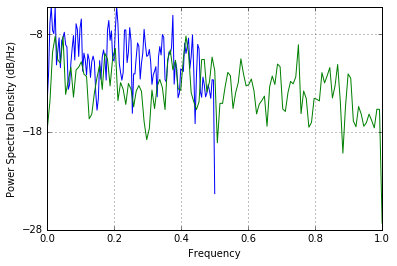

In [113]:
blah = psd(pphase,Fs=1.)
blah=psd(naive)
#ylim(-9,5)

In [172]:
%timeit same.polyphase(x)

1000 loops, best of 3: 943 µs per loop


In [253]:
%timeit doubling.polyphase(x)

100 loops, best of 3: 4.56 ms per loop


In [248]:
freqs = np.logspace(-3,0,1024).astype('float32')
mags = []
tt = np.arange(2**18)
for k,freq in enumerate(freqs):
    x = np.sin(np.pi*tt*freq+np.random.uniform(0,2*np.pi)).astype('float32')
    mags.append(np.sum(np.abs(doubling.polyphase(x)[256:512])**2))
    

In [249]:
mags = np.array(mags)

(-120, 10)

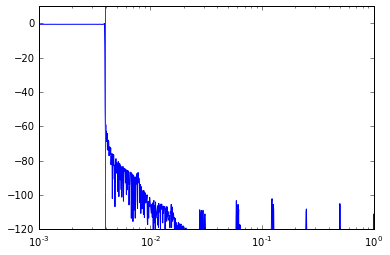

In [255]:
semilogx(freqs,10*np.log10(mags/mags.max()))
axvline(1/256.,color='r')
ylim(-120,10)

In [209]:
def dB(x):
    return 20*np.log10(np.abs(x))

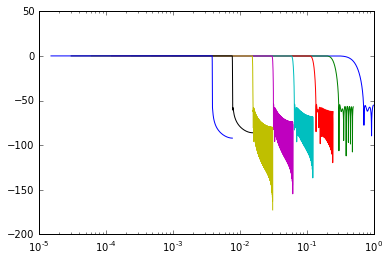

In [215]:
for k,filter_ in enumerate(doubling.filters):
    w,H = signal.freqz(filter_.coeff,1)
    H = dB(H)
    semilogx(w/(2**k*np.pi),H)

(-0.005, 0.005)

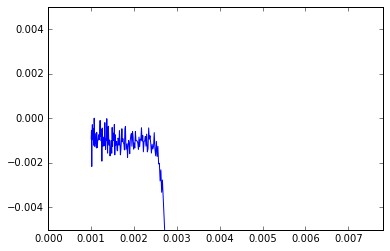

In [170]:
plot(freqs,mags/mags.max()-1)
xlim(0,1/128.)
ylim(-.005,0.005)

In [254]:
(2**18/4.5e-3)/1e6

58.254222222222225

In [129]:
ppsame = same.polyphase(x)
ppdoub = doubling.polyphase(x)

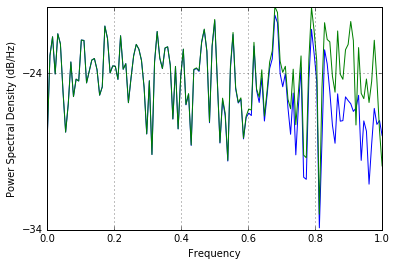

In [130]:
blah = psd(ppsame)
blah = psd(ppdoub)

In [131]:
ppsame.shape

(1024,)

In [84]:
naive.dtype

dtype('float32')

In [85]:
pphase.dtype

dtype('float32')

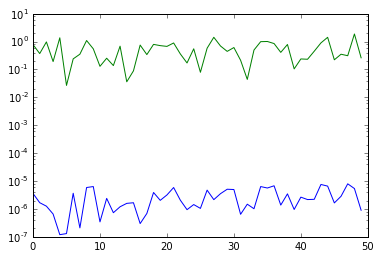

In [86]:
plot(np.abs((naive[:100:2]-pphase[:50])))
plot(np.abs(naive[:100:2]))
yscale('log')

In [ ]:
signal.ch

In [25]:
signal.firwin?

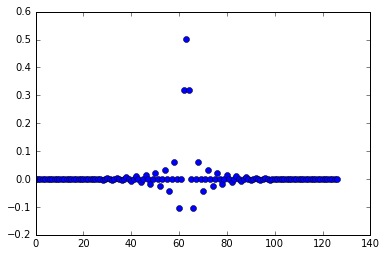

In [36]:
h = signal.firwin(127,0.5,window=('chebwin',80))
h[np.abs(h)<1e-14]=0
plot(h,'o')

In [37]:
h[::2].shape

(64,)

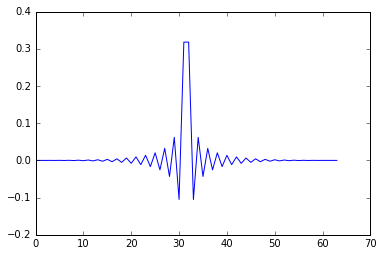

In [42]:
plot(h[::2])

In [39]:
w,H = signal.freqz(h,1)

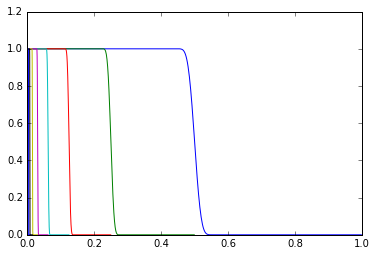

In [41]:
for k in range(8):
    plot(w/(2**k*np.pi),np.abs(H))
#    axvline(0.5)


In [13]:
x = np.zeros((512,2**12),dtype=np.complex64)

In [23]:
y = np.zeros((512,2,2**12),dtype=np.float32)

In [26]:
%timeit y[:]=np.transpose(x.view(np.float32).reshape((512,2**12,2)),(0,2,1)).copy()

100 loops, best of 3: 5.28 ms per loop


In [22]:
np.copy?

In [15]:
%timeit x.copy()

100 loops, best of 3: 2.43 ms per loop


In [6]:
((2**21*2*4)/2.3e-3)/1e6

7294.441739130435

In [20]:
25/7.2

3.4722222222222223

In [305]:
x = np.ones((16,))
b = np.abs(np.random.randn(4))

In [306]:
full = np.convolve(x,b,mode='full')
valid = np.convolve(x,b,mode='valid')
same = np.convolve(x,b,mode='same')

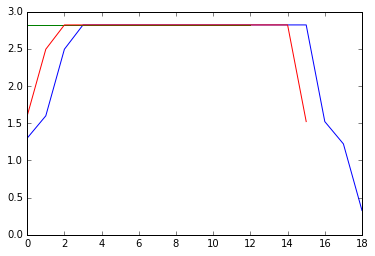

In [307]:
plot(full)
plot(valid)
plot(same)

In [308]:
full1 = np.convolve(x[:8],b,mode='full')
full2 = np.convolve(x[8:],b,mode='full')
y = np.zeros((19,))
y[-11:] = full2

In [309]:
full1.shape

(11,)

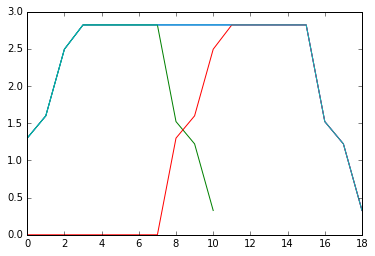

In [310]:
plot(full)
plot(full1)
plot(y)
y[:11] += full1
plot(y)